# Forecasting the Sales of a Supermarket During a Festive Season

## Problem

* TODO: Write down the problem explicitly!

## Solution Overview

* We use the dataset provided by [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data) challenge. It is the historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments. We will use this data to predict the department-wise sales for each store in the Christmas.

* The dataset consists of 4 files (TODO: Add file description)
    * `stores.csv`
    * `train.csv`
    * `test.csv`
    * `features.csv`

## EDA and Data Cleaning

In [1]:
from pyspark.sql import SparkSession

from pyspark.sql import types

from pyspark.sql.functions import col

from pyspark.sql.functions import date_format

from datetime import datetime
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [124]:
from scipy.special import boxcox1p

In [2]:
import warnings
# ignore warnings
warnings.filterwarnings("ignore")

In [3]:
spark = (SparkSession.builder
         .appName("Business Intelligence Capstone")
         .master("local[*]")
         .getOrCreate())

23/02/14 21:32:15 WARN Utils: Your hostname, hungnd-HP440G5 resolves to a loopback address: 127.0.1.1; using 192.168.2.9 instead (on interface wlp2s0)
23/02/14 21:32:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/02/14 21:32:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


* Load the Stores

In [4]:
store_schema = types.StructType([
  types.StructField("Store", types.StringType(), nullable=False),
  types.StructField("Type", types.StringType(), nullable=False),
  types.StructField("Size", types.IntegerType(), nullable=False)
])


store_df = (spark.read
            .option("header", "true")
            .option("schema", store_schema)
            .csv("../data/stores.csv")
            .withColumnRenamed("Store", "store")
            .withColumnRenamed("Type", "type")
            .withColumnRenamed("Size", "size"))

In [5]:
store_df.show(5)

+-----+----+------+
|store|type|  size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
+-----+----+------+
only showing top 5 rows



In [6]:
store_df.createOrReplaceTempView("stores")

* Load the Train and Features Dataset

In [7]:
%%time

train_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")
            .csv("../data/train.csv")
            .select(
              col("Store").cast(types.StringType()).alias("store"),
              col("Dept").cast(types.StringType()).alias("dept"),
              col("Date").cast(types.DateType()).alias("date"),
              col("Weekly_Sales").alias("weekly_sales"),
              col("IsHoliday").alias("is_holiday")
            ))

[Stage 3:==============>                                            (1 + 3) / 4]

CPU times: user 15.7 ms, sys: 13 µs, total: 15.7 ms
Wall time: 1.59 s


In [8]:
train_df.printSchema()

root
 |-- store: string (nullable = true)
 |-- dept: string (nullable = true)
 |-- date: date (nullable = true)
 |-- weekly_sales: double (nullable = true)
 |-- is_holiday: boolean (nullable = true)



In [9]:
train_df.createOrReplaceTempView("train")

In [10]:
features_df = (spark.read
               .option("header", "true")
               .option("inferSchema", "true")
               .csv("../data/features.csv")
               .select(
                 col("Store").cast(types.StringType()).alias("store"),
                 col("Date").cast(types.DateType()).alias("date"),
                 col("Temperature").alias("temperature"),
                 col("Fuel_Price").alias("fuel_price"),
                 col("MarkDown1").cast(types.DoubleType()).alias("markdown_1"),
                 col("MarkDown2").cast(types.DoubleType()).alias("markdown_2"),
                 col("MarkDown3").cast(types.DoubleType()).alias("markdown_3"),
                 col("MarkDown4").cast(types.DoubleType()).alias("markdown_4"),
                 col("MarkDown5").cast(types.DoubleType()).alias("markdown_5"),
                 col("CPI").alias("cpi"),
                 col("Unemployment").cast(types.DoubleType()).alias("unemployment"),
                 col("IsHoliday").alias("is_holiday")))

In [11]:
features_df.createOrReplaceTempView("features")

In [12]:
features_df.printSchema()

root
 |-- store: string (nullable = true)
 |-- date: date (nullable = true)
 |-- temperature: double (nullable = true)
 |-- fuel_price: double (nullable = true)
 |-- markdown_1: double (nullable = true)
 |-- markdown_2: double (nullable = true)
 |-- markdown_3: double (nullable = true)
 |-- markdown_4: double (nullable = true)
 |-- markdown_5: double (nullable = true)
 |-- cpi: string (nullable = true)
 |-- unemployment: double (nullable = true)
 |-- is_holiday: boolean (nullable = true)



* Merge `train` with `features` and `stores`

In [98]:
train_features = spark.sql(
  """
  select t.store, t.dept, 
         t.date, t.weekly_sales,
         s.type, s.size,
         f.temperature, f.fuel_price, 
         f.markdown_1, f.markdown_2, f.markdown_3, f.markdown_4, f.markdown_5,
         f.cpi, f.unemployment, f.is_holiday
  from train t, features f, stores s
  where (t.store = f.store and t.date = f.date and t.store = s.store)
  """)

In [99]:
train_features.createOrReplaceTempView("train_features")

In [100]:
spark.sql(
  """
  select distinct date_format(date, "EEEE") as day_of_week
  from train_features
  """
).show()

+-----------+
|day_of_week|
+-----------+
|     Friday|
+-----------+



* The `date` field does not represent the day, but the friday of every week in a year. We will create two field `year` and `week` to make the problem more general.

In [101]:
train_features = (train_features
                  .withColumn("year", date_format(col("date"), "y"))
                  .withColumn("week", date_format(col("date"), "w")))

In [102]:
train_features.createOrReplaceTempView("train_features")

In [103]:
spark.sql(
  """
  select distinct year
  from train_features
  """).show()

+----+
|year|
+----+
|2012|
|2011|
|2010|
+----+



* Next, we will have to mark Christmas weeks (a Christmas week is a week containing the Christmas day). Christmas is always on December 25th so we will mark the week containing `2010-12-25`, `2011-12-25`, `2012-12-25` days as Christmas.

In [104]:
print("year=2010, week={}".format(date(2010, 12, 25).isocalendar()[1]))
print("year=2011, week={}".format(date(2011, 12, 25).isocalendar()[1]))
print("year=2012, week={}".format(date(2012, 12, 25).isocalendar()[1]))

year=2010, week=51
year=2011, week=51
year=2012, week=52


In [105]:
train_features = spark.sql(
  """
  select *,
         case when year = 2010 and week = 51 then true
              when year = 2011 and week = 51 then true
              when year = 2012 and week = 52 then true
              else false
         end as is_christmas
  from train_features
  """)

In [106]:
train_features.createOrReplaceTempView("train_features")

In [107]:
train_features.where(col("is_christmas")).count()

5972

In [108]:
train_features.count()

421570

In [109]:
train_features.cache()

DataFrame[store: string, dept: string, date: date, weekly_sales: double, type: string, size: string, temperature: double, fuel_price: double, markdown_1: double, markdown_2: double, markdown_3: double, markdown_4: double, markdown_5: double, cpi: string, unemployment: double, is_holiday: boolean, year: string, week: string, is_christmas: boolean]

* **Question: Was Christmas the time when the stores mark the highest numbers in sales?**

In [110]:
weekly_sales = spark.sql(
  """
  select year, week, 
         avg(weekly_sales) as mean_sales,
         percentile_approx(weekly_sales, 0.5) as median_sales
  from train_features
  group by year, week
  order by year, week
  """
)

In [111]:
weekly_sales_df = weekly_sales.toPandas()

In [112]:
weekly_sales_df["year"] = weekly_sales_df["year"].astype(np.int32)
weekly_sales_df["week"] = weekly_sales_df["week"].astype(np.int32)

In [113]:
weekly_sales_2010 = weekly_sales_df[weekly_sales_df["year"] == 2010].sort_values("week")
weekly_sales_2011 = weekly_sales_df[weekly_sales_df["year"] == 2011].sort_values("week")
weekly_sales_2012 = weekly_sales_df[weekly_sales_df["year"] == 2012].sort_values("week")

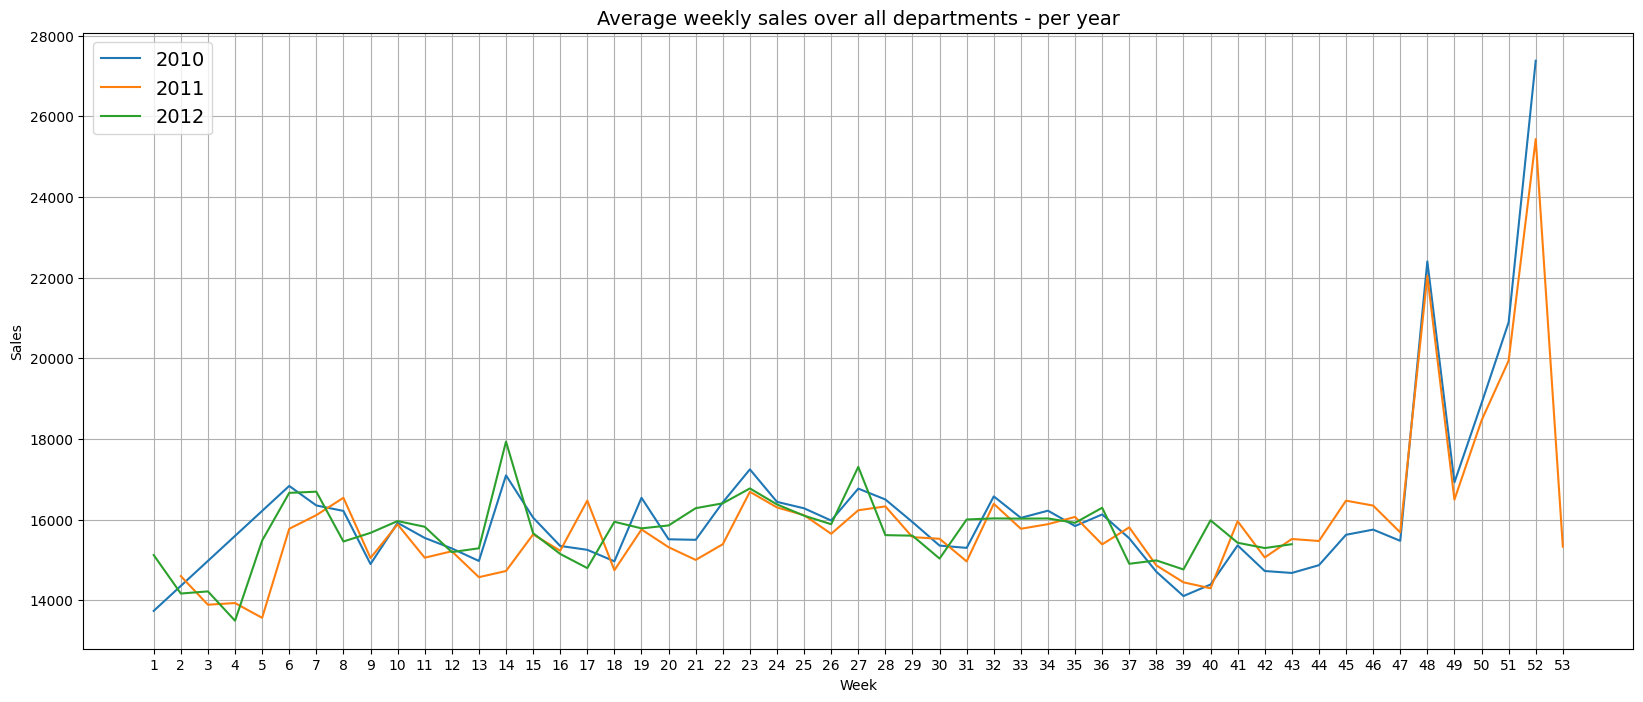

In [114]:
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()

line_2010, = ax.plot(weekly_sales_2010["week"], weekly_sales_2010["mean_sales"], label="2010")
line_2011, = ax.plot(weekly_sales_2011["week"], weekly_sales_2011["mean_sales"], label="2011")
line_2012, = ax.plot(weekly_sales_2012["week"], weekly_sales_2012["mean_sales"], label="2012")

ax.grid()
ax.set_xticks(np.arange(1, 54))
ax.legend(handles=[line_2010, line_2011, line_2012], loc="best", fontsize=14)
ax.set_title("Average weekly sales over all departments - per year", fontsize=14)
ax.set(xlabel="Week", ylabel="Sales")

plt.savefig("weekly_sales_mean.png")
plt.show()

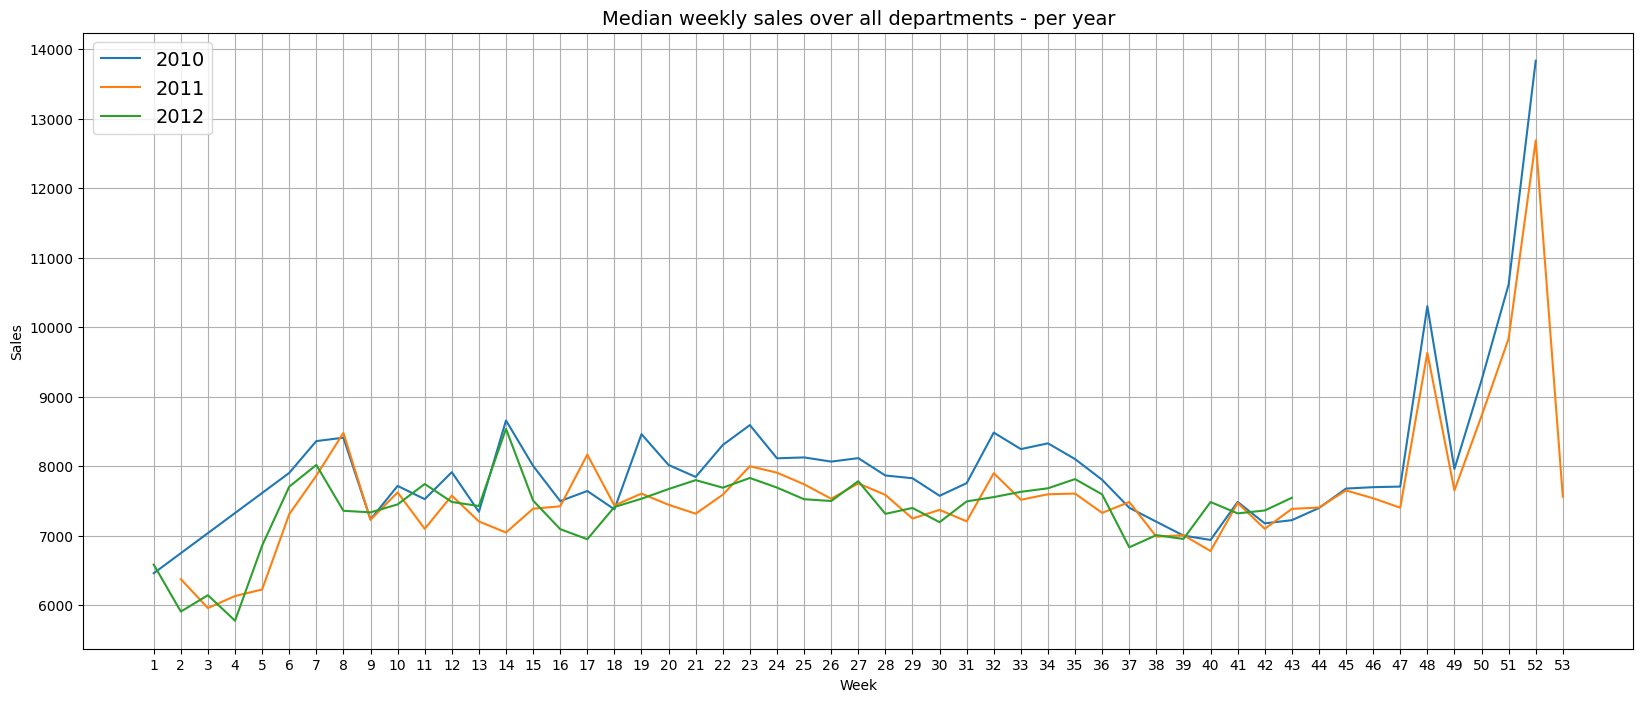

In [115]:
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()

line_2010, = ax.plot(weekly_sales_2010["week"], weekly_sales_2010["median_sales"], label="2010")
line_2011, = ax.plot(weekly_sales_2011["week"], weekly_sales_2011["median_sales"], label="2011")
line_2012, = ax.plot(weekly_sales_2012["week"], weekly_sales_2012["median_sales"], label="2012")

ax.grid()
ax.set_xticks(np.arange(1, 54))
ax.legend(handles=[line_2010, line_2011, line_2012], loc="best", fontsize=14)
ax.set_title("Median weekly sales over all departments - per year", fontsize=14)
ax.set(xlabel="Week", ylabel="Sales")

plt.savefig("weekly_sales_median.png")
plt.show()

* As can be seen from the line chart, sales rocketed during Christmas for 2010 and 2011. For 2012, we have no data about the sales since the 43rd week. The challenge will ask to predict the sales for remaining part of the year 2012.

## Modeling

* In this part, we will build a machine learning model to predict the sales for each department in Christmas season of 2012 given the historical data of 2010 and 2011. To be more specific, for each department in a store, the model will predict its `weekly_sales` for Christmas in 2012 given their sales data in 2010, 2011 and the early 2012.

### Dimensionality Reduction

* For the modeling part, we will perform feature selection to select some meaningful features for training our model.

* We can drop `markdown_*` features because it contains a lot of null values (approximately 70 percent), so relying on it is unreliable.

In [116]:
spark.sql(
  """
  select 'markdown_1' as feature,
         sum(case when markdown_1 is null then 1 else 0 end) as null_count,
         sum(case when markdown_1 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_2' as feature,
         sum(case when markdown_2 is null then 1 else 0 end) as null_count,
         sum(case when markdown_2 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_3' as feature,
         sum(case when markdown_3 is null then 1 else 0 end) as null_count,
         sum(case when markdown_3 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_4' as feature,
         sum(case when markdown_4 is null then 1 else 0 end) as null_count,
         sum(case when markdown_4 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_5' as feature,
         sum(case when markdown_5 is null then 1 else 0 end) as null_count,
         sum(case when markdown_5 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  """).show()

+----------+----------+------------------+
|   feature|null_count|          null_pct|
+----------+----------+------------------+
|markdown_1|    270889|0.6425718148824632|
|markdown_2|    310322|0.7361102545247528|
|markdown_3|    284479|0.6748084541120098|
|markdown_4|    286603|0.6798467632896079|
|markdown_5|    270138|0.6407903788220224|
+----------+----------+------------------+



* It seems to be no correlation between `fuel_price`/`temperature`/`cpi`/`unemployment` and `weekly_sales`

In [118]:
train_no_markdown = spark.sql(
  """
  select store, dept, year, week, type, size, temperature, fuel_price, cpi, unemployment, 
         is_holiday, weekly_sales
  from train_features
  """).toPandas()

In [149]:
train_no_markdown["store"] = train_no_markdown["store"].astype(np.int64)
train_no_markdown["dept"] = train_no_markdown["dept"].astype(np.int64)
train_no_markdown["year"] = train_no_markdown["year"].astype(np.int64)
train_no_markdown["week"] = train_no_markdown["week"].astype(np.int64)
train_no_markdown["type"] = train_no_markdown["type"].map({"A": 3, "B": 2, "C": 1})

In [151]:
train_no_markdown["size"] = train_no_markdown["size"].astype(np.int64)
train_no_markdown["cpi"] = train_no_markdown["cpi"].astype(np.float64)

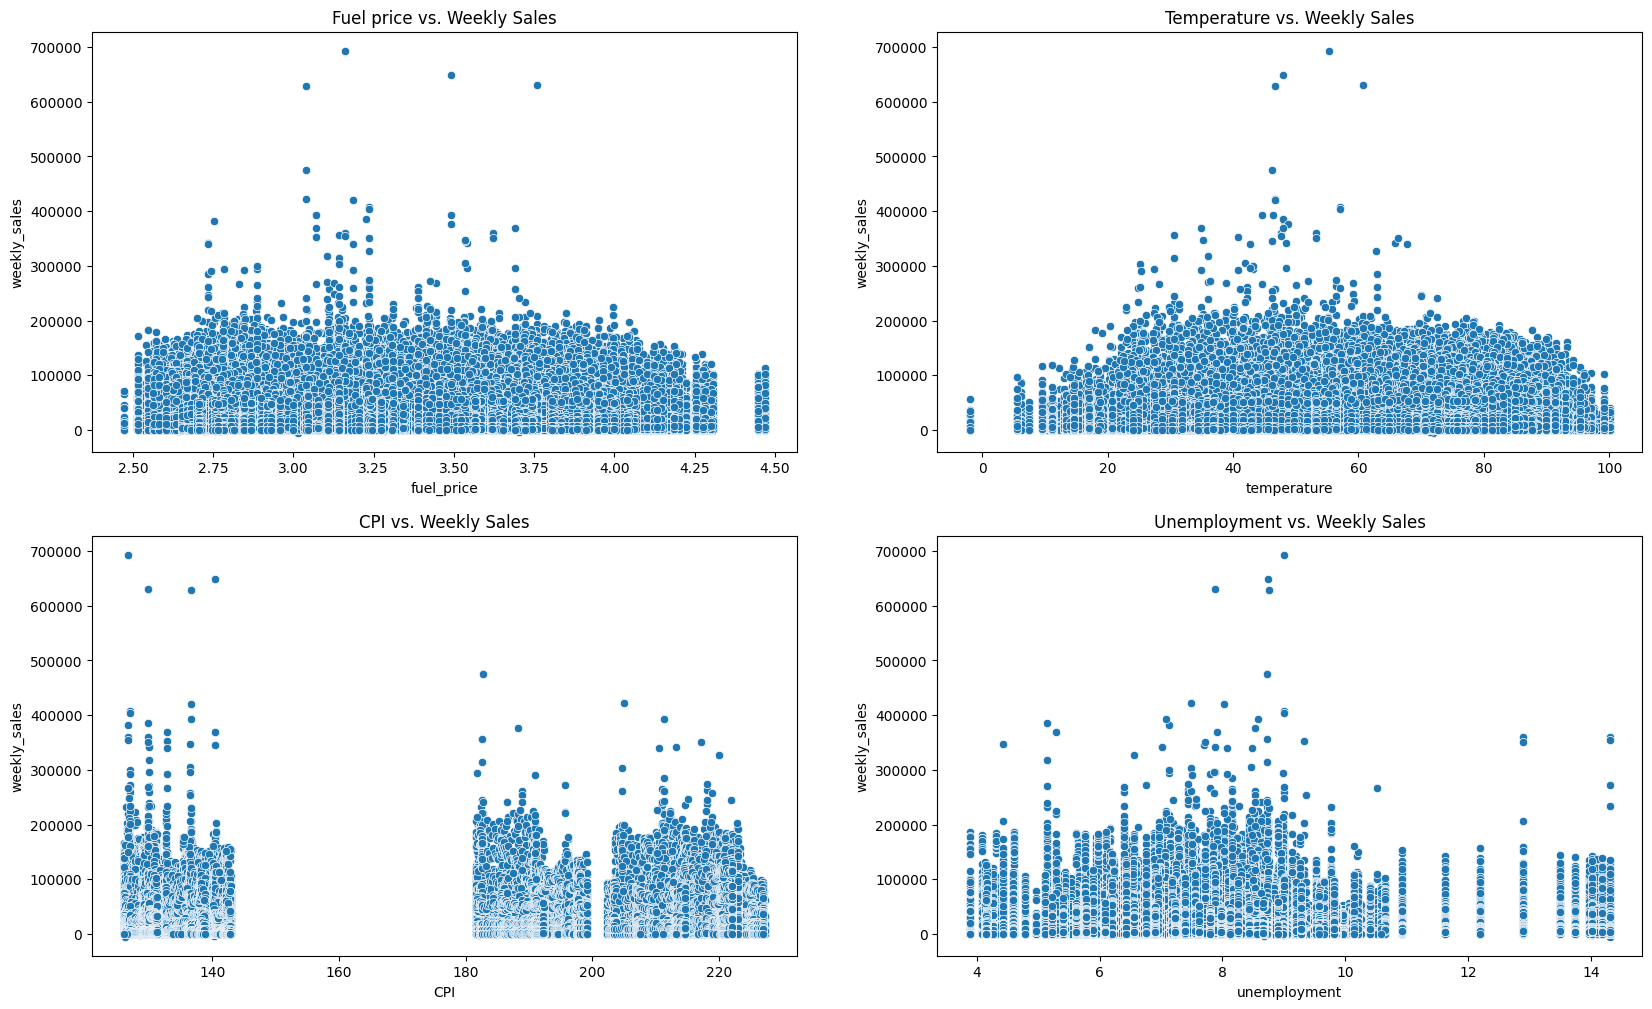

In [152]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

sns.scatterplot(data=train_no_markdown,
                y="weekly_sales",
                x="fuel_price",
                ax=ax1)
ax1.set(xlabel="fuel_price", ylabel="weekly_sales")
ax1.set_title("Fuel price vs. Weekly Sales")

sns.scatterplot(data=train_no_markdown,
                y="weekly_sales",
                x="temperature",
                ax=ax2)
ax2.set(xlabel="temperature", ylabel="weekly_sales")
ax2.set_title("Temperature vs. Weekly Sales")

sns.scatterplot(data=train_no_markdown,
                y="weekly_sales",
                x="cpi",
                ax=ax3)
ax3.set(xlabel="CPI", ylabel="weekly_sales")
ax3.set_title("CPI vs. Weekly Sales")

sns.scatterplot(data=train_no_markdown,
                y="weekly_sales",
                x="unemployment",
                ax=ax4)
ax4.set(xlabel="unemployment", ylabel="weekly_sales")
ax4.set_title("Unemployment vs. Weekly Sales")

plt.show()

In [153]:
feature_cols = ["store", "dept", "year", "week", "type", "size", "is_holiday"]
target_col = ["weekly_sales"]

### Cost Function

In [164]:
def WMAE(dataset, real, predicted):
    weights = dataset["is_holiday"].map({True: 5, False: 1}).values
    return np.round(np.sum(weights * np.abs(real - predicted)) / np.sum(weights), 2)

### Modeling

In [188]:
X = train_no_markdown[feature_cols]
y = train_no_markdown[target_col]

### Linear Regression

In [189]:
from sklearn.linear_model import LinearRegression

In [190]:
linear_regression = LinearRegression().fit(X, y)

In [207]:
train_preds = linear_regression.predict(X)[:, 0]
train_wmae = WMAE(X, y['weekly_sales'], train_preds)
print('The WMAE loss for the training set is {}.'.format(train_wmae))

The WMAE loss for the training set is 14808.02.


#### Random Forest

In [155]:
from sklearn.ensemble import RandomForestRegressor

In [193]:
random_forest = RandomForestRegressor(max_depth=14, random_state=1).fit(X, y)

In [197]:
train_preds = random_forest.predict(X)
train_wmae = WMAE(X, y['weekly_sales'], train_preds)
print('The WMAE loss for the training set is {}.'.format(train_wmae))

The WMAE loss for the training set is 2214.1.


## Evaluation

### Load the Test Dataset

In [69]:
%%time

test_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")
            .csv("../data/test.csv")
            .select(
              col("Store").cast(types.StringType()).alias("store"),
              col("Dept").cast(types.StringType()).alias("dept"),
              col("Date").cast(types.DateType()).alias("date"),
              col("IsHoliday").alias("is_holiday")
            ))

CPU times: user 5.14 ms, sys: 8.65 ms, total: 13.8 ms
Wall time: 819 ms


In [70]:
test_df.createOrReplaceTempView("test")

In [136]:
test_features = spark.sql(
  """
    select t.store, t.dept, 
           date_format(t.date, "y") as year,
           date_format(t.date, "w") as week,
           s.type, s.size,
           f.is_holiday
  from test t, features f, stores s
  where (t.store = f.store and t.date = f.date and t.store = s.store)
  """)

In [137]:
test_features_df = test_features.toPandas()

### Making Predictions for Christmas

* Making Predictions

In [195]:
test_features_df["store"] = test_features_df["store"].astype(np.int64)
test_features_df["dept"] = test_features_df["dept"].astype(np.int64)
test_features_df["year"] = test_features_df["year"].astype(np.int64)
test_features_df["week"] = test_features_df["week"].astype(np.int64)
test_features_df["type"] = test_features_df["type"].map({"A": 3, "B": 2, "C": 1})

In [198]:
X_test = test_features_df[feature_cols]

In [199]:
test_preds = random_forest.predict(X_test)

In [202]:
test_features_df["weekly_sales"] = test_preds

In [208]:
christmas_df = test_features_df[(test_features_df["year"] == 2012) & (test_features_df["week"].isin({52}))]

In [210]:
christmas_df.head()

,store,dept,year,week,type,size,is_holiday,weekly_sales
8,1,1,2012,52,3,151315,True,36976.283796
47,1,2,2012,52,3,151315,True,56573.903268
86,1,3,2012,52,3,151315,True,13364.733480
125,1,4,2012,52,3,151315,True,36322.350667
164,1,5,2012,52,3,151315,True,64810.910944
